In [1]:
cd ../task_01/pipelines

/Users/pldelacour/Documents/PL_Ecole/data_sc_lab/data_sc_lab/task_01/pipelines


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipynb.fs.full.tool_functions import *
from yellowbrick.regressor import AlphaSelection
from sklearn.model_selection import train_test_split
from numpy import mean
from numpy import std
from sklearn.model_selection import RepeatedKFold
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau

/Users/pldelacour/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


In [3]:
df_beha = pd.read_csv('../../../data/Behavioral/AllData.csv')#, nrows=1000)

df_spectro_cluster = pd.read_csv("../../../data/EEG/RestingEEG_Spectro_Cluster.csv") #, nrows=1000)

srs = pd.read_csv('../../../data/HBN_srs.csv', delimiter=';')
outliers = pd.read_csv('../../../data/outliers.csv')

/Users/pldelacour/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (66,68,80,81,82,83,84,95,96,97,98,99,110,111,112,113,114,125,126,127,128,129,140,141,142,144,155,156,157,159,932,933,934,935,936,937,938,939,940,941,942,943,944,945,946,947,948,949,950,951,952,953,954,955,956,957,958,959,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024,1025,1026,1027,1028,1029,1030,1031,1032,1033,1034,1035,1036,1037,1038,1039,1040,1041,1042,1043,1044,1045,1046,1047,1048,1049,1050,1051,1052,1053,1054,1055,1056,1057,1058,1059,1060,1061,1062,1063,1064,1065,1066,1067,1068,1069,1070,1071,1072,1073,1074,1075,1076,1077,1078,1079,1080,1081,1082,1083,1084,1085,1086,1087,1088,1089,1090,1091,1092,1093,1094,1095,1096,1097,1098,1099,11

## SWAN 

In [4]:
swan = df_beha[['SWAN_IN_Avg' , 'SWAN_HY_Avg', 'Patient_ID']]
in_null = swan['SWAN_IN_Avg'].isnull().sum()
hy_null = swan['SWAN_HY_Avg'].isnull().sum()
#print(in_null)
#print(hy_null)
swan = swan[~ (swan['SWAN_IN_Avg'].isnull() | swan['SWAN_HY_Avg'].isnull()) ]

## SRS

In [6]:
srs = srs[~srs['SRS_RRB'].isnull()]
srs.rename(columns={'IDs': 'Patient_ID'}, inplace=True)

In [7]:
scores = pd.merge(swan , srs , on = 'Patient_ID')
scores

,SWAN_IN_Avg,SWAN_HY_Avg,Patient_ID,Sex,Age,SRS_RRB,SRS_SCI,SRS_Total
0,0.000000,1.222222,NDARYM832PX3,1,7.048254,10.0,45.0,55.0
1,1.222222,0.555555,NDARNJ687DMC,1,6.348163,19.0,73.0,92.0
2,1.111111,1.888888,NDARED632KNG,1,17.203855,2.0,28.0,30.0
3,-0.111111,2.222222,NDARFM080VAF,1,7.623203,14.0,72.0,86.0
4,-0.111111,0.777777,NDARFW130NGG,1,8.316107,25.0,85.0,110.0
...,...,...,...,...,...,...,...,...
1234,-1.444444,-2.333333,NDARND697FLK,1,6.517796,1.0,17.0,18.0
1235,1.222222,0.444444,NDARCL008HLA,0,16.456194,21.0,82.0,103.0
1236,-1.888888,-3.000000,NDARYM334BZ5,0,16.119438,0.0,6.0,6.0
1237,-0.666666,1.333333,NDARYZ986HEW,1,7.563084,9.0,49.0,58.0


## Combine With spectro

In [8]:
df_spectro_cluster.rename(columns={'id': 'Patient_ID'}, inplace=True)
df_label_spectro_cluster = pd.merge(scores,  df_spectro_cluster, on='Patient_ID')

df_label_spectro_cluster = fill_with_median(df_label_spectro_cluster)

In [9]:
less_18 = df_label_spectro_cluster['Age'] <= 18.0
df_label_spectro_cluster = df_label_spectro_cluster[less_18]

In [10]:
# Remove preidentified outliers

In [11]:
outliers = pd.read_csv('../../../data/outliers.csv')
df_label_spectro_cluster = df_label_spectro_cluster[~df_label_spectro_cluster.Patient_ID.isin(outliers.Patient_ID)]

## Train test split

In [12]:
X = df_label_spectro_cluster.drop([ 'SWAN_IN_Avg' , 'SWAN_HY_Avg', 'SRS_Total' , 'SRS_RRB' , 'SRS_SCI', 'Patient_ID'], axis=1)
Y = df_label_spectro_cluster[[ 'SWAN_IN_Avg' , 'SWAN_HY_Avg', 'SRS_Total' , 'SRS_RRB' , 'SRS_SCI']]


In [13]:
X

,Sex,Age,eyesclosed_fband_delta_absmean_lfront,eyesclosed_fband_delta_absmean_mfront,eyesclosed_fband_delta_absmean_rfront,eyesclosed_fband_delta_absmean_lpari,eyesclosed_fband_delta_absmean_mpari,eyesclosed_fband_delta_absmean_rpari,eyesclosed_fband_delta_relmean_lfront,eyesclosed_fband_delta_relmean_mfront,...,eyesopen_fooof_peak_freq_rfront,eyesopen_fooof_peak_freq_lpari,eyesopen_fooof_peak_freq_mpari,eyesopen_fooof_peak_freq_rpari,eyesopen_fooof_peak_amplitude_lfront,eyesopen_fooof_peak_amplitude_mfront,eyesopen_fooof_peak_amplitude_rfront,eyesopen_fooof_peak_amplitude_lpari,eyesopen_fooof_peak_amplitude_mpari,eyesopen_fooof_peak_amplitude_rpari
0,1,7.623203,7.519803,7.043891,6.528158,9.633529,9.989483,9.305804,9.598653,10.164125,...,9.485781,9.441022,9.384172,9.425798,0.795549,0.876262,0.872379,0.989101,1.099981,0.915441
1,0,10.835158,2.346685,3.945786,2.962716,3.440606,3.565384,3.023286,10.968235,12.461058,...,8.800915,8.510134,9.078390,14.741810,0.254701,0.351010,0.303875,0.234960,0.232564,0.344537
2,0,7.987451,1.281869,1.229748,1.905450,1.768091,1.484286,0.756394,13.132905,11.998897,...,5.604535,5.602136,4.096616,5.084040,0.048655,0.233294,0.282735,0.256238,0.175123,0.304286
3,1,8.096851,3.109075,4.803264,2.873502,2.644382,3.884837,2.391569,9.931212,10.869944,...,9.288451,6.651558,6.396867,10.291086,0.218827,0.313734,0.298905,0.178899,0.108880,0.449437
4,0,8.357061,5.786769,6.818487,6.296279,8.043145,9.413683,6.839451,10.495082,11.095547,...,6.952035,5.065536,4.679294,4.924409,0.150518,0.169058,0.154417,0.104574,0.102992,0.094126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
901,1,6.517796,8.594610,13.258798,7.158682,12.743212,8.698643,4.855232,15.315470,14.779320,...,5.868008,22.846455,7.050818,4.622321,0.416442,0.358625,0.380528,0.169463,0.325197,0.199935
902,0,16.456194,7.487871,9.809903,7.255467,8.731814,9.629680,11.326718,7.404931,7.060421,...,9.389994,9.540163,9.482167,9.545163,1.326583,1.288238,1.407225,1.561878,1.636154,1.412149
903,0,16.119438,3.743134,3.795633,3.286381,2.779438,3.539956,3.800533,8.565498,8.383859,...,10.376962,10.707490,10.383040,10.343315,0.623514,0.582917,0.422394,0.615360,0.860283,0.945789
904,1,7.563084,2.830657,5.259391,6.724664,4.745513,5.885628,3.160138,13.388712,13.121943,...,9.482208,7.101976,9.409898,9.301044,0.185029,0.165101,0.246363,0.120704,0.254212,0.271848


In [14]:
x_train , x_test, y_train , y_test = train_test_split(X,Y, test_size=0.2, random_state = 0)

In [15]:
forest = IsolationForest()
forest.fit(x_train)

# Outlier indices for training
outliers_training = forest.predict(x_train)
outliers_training_indices = np.argwhere(outliers_training == 1).flatten()

# Drop signal outliers in training data
x_train = x_train[outliers_training == 1]
y_train = y_train[outliers_training == 1]
#x_train, y_train = drop_outliers_samples_isolation_forest(x_train, y_train)
print(outliers_training_indices)
print(x_test.shape)
print(y_test.shape)
print(x_train.shape)
print(y_train.shape)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  17  18
  19  20  22  23  25  26  27  28  29  30  31  32  33  34  35  36  37  38
  39  40  41  42  43  44  45  47  49  50  51  52  53  54  55  57  58  59
  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77
  78  79  80  81  82  83  84  85  86  87  88  89  90  92  93  94  95  97
  98  99 100 101 102 103 104 105 106 107 108 109 110 113 114 115 116 117
 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135
 136 137 138 139 140 141 142 143 144 145 146 147 148 150 151 152 153 154
 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172
 173 174 175 176 177 178 179 181 182 183 184 185 186 187 188 189 190 191
 192 193 194 195 196 197 198 199 200 203 204 205 207 208 209 210 211 212
 213 214 215 216 219 220 221 222 223 224 225 226 227 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251
 252 253 254 255 256 257 258 259 260 261 263 264 26

In [16]:
scaler = StandardScaler()
scaler.fit(x_train)
x_train = pd.DataFrame(scaler.transform(x_train), columns=x_train.columns, index=x_train.index)
x_test = pd.DataFrame(scaler.transform(x_test), columns=x_test.columns, index=x_test.index)


In [18]:
## no need to scale y if r^2 is used

## Model 

In [36]:
# get the dataset
 
# get the model
def get_model(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(50, input_dim=n_inputs, activation='relu'))
    model.add(Dense(50, input_dim=n_inputs, activation='relu'))
    model.add(Dense(50, input_dim=n_inputs, activation='relu'))
    model.add(Dense(50, input_dim=n_inputs, activation='relu'))
    model.add(Dense(50, input_dim=n_inputs, activation='relu'))
    model.add(Dense(n_outputs, activation=None))
    model.compile(loss='mse' , optimizer='adam')
    return model
 
# evaluate a model using repeated k-fold cross-validation
def evaluate_model(X, y):
    results = list()
    n_inputs, n_outputs = X.shape[1], y.shape[1]
    
    # define evaluation procedure
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    # enumerate folds
    for train_ix, test_ix in cv.split(X):
        # prepare data
        X_train, X_test = X[train_ix], X[test_ix]
        y_train, y_test = y[train_ix], y[test_ix]
        # define model
        model = get_model(n_inputs, n_outputs)
        # fit model
        model.fit(X_train, y_train, verbose=0, epochs=100)
        # evaluate model on test set
        mae = model.evaluate(X_test, y_test, verbose=0)
        # store result
        print('>%.3f' % mae)
    results.append(mae)
    return results


In [37]:
checkpointer = ModelCheckpoint(filepath='Best_model.h5', monitor='val_mse', verbose=1, save_best_only=True)
model = get_model(x_train.shape[1] , y_train.shape[1])
file_path = "best_model.h5"
checkpoint = ModelCheckpoint(file_path, monitor='mse', verbose=1, save_best_only=True, mode='max')

###
early = EarlyStopping(monitor="mse", mode="max", patience=10, verbose=1)
redonplat = ReduceLROnPlateau(monitor="mse", mode="max", patience=3, verbose=2)
callbacks_list = [checkpoint, early, redonplat]  # early
###
hist = model.fit(
    x_train.to_numpy(), 
    y_train.to_numpy(), 
    validation_split = 1/6,
    batch_size=275, epochs=400, verbose=2, shuffle=True, 
    callbacks=[checkpointer])
model.load_weights('Best_model.h5')

Train on 559 samples, validate on 112 samples
Epoch 1/400
 - 0s - loss: 1387.7637 - val_loss: 1130.3320
Epoch 2/400
 - 0s - loss: 1378.0647 - val_loss: 1122.4506
Epoch 3/400
 - 0s - loss: 1368.9895 - val_loss: 1111.4056
Epoch 4/400
 - 0s - loss: 1355.8386 - val_loss: 1094.6815
Epoch 5/400
 - 0s - loss: 1335.3215 - val_loss: 1069.4709
Epoch 6/400
 - 0s - loss: 1304.5458 - val_loss: 1031.6399
Epoch 7/400
 - 0s - loss: 1257.3300 - val_loss: 976.7549
Epoch 8/400
 - 0s - loss: 1188.2828 - val_loss: 903.3658
Epoch 9/400
 - 0s - loss: 1096.2655 - val_loss: 810.5538
Epoch 10/400
 - 0s - loss: 973.7793 - val_loss: 705.6154
Epoch 11/400
 - 0s - loss: 833.6876 - val_loss: 617.8255
Epoch 12/400
 - 0s - loss: 708.1672 - val_loss: 566.5684
Epoch 13/400


/Users/pldelacour/anaconda3/lib/python3.7/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_mse available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


 - 0s - loss: 634.1066 - val_loss: 566.1578
Epoch 14/400
 - 0s - loss: 607.2837 - val_loss: 558.2546
Epoch 15/400
 - 0s - loss: 576.5844 - val_loss: 492.9097
Epoch 16/400
 - 0s - loss: 515.0364 - val_loss: 432.6848
Epoch 17/400
 - 0s - loss: 475.8128 - val_loss: 407.8914
Epoch 18/400
 - 0s - loss: 461.5101 - val_loss: 406.9505
Epoch 19/400
 - 0s - loss: 456.9912 - val_loss: 408.1224
Epoch 20/400
 - 0s - loss: 452.8673 - val_loss: 390.5879
Epoch 21/400
 - 0s - loss: 450.2442 - val_loss: 378.8035
Epoch 22/400
 - 0s - loss: 443.6092 - val_loss: 369.1157
Epoch 23/400
 - 0s - loss: 434.0284 - val_loss: 363.1917
Epoch 24/400
 - 0s - loss: 425.8085 - val_loss: 356.4323
Epoch 25/400
 - 0s - loss: 421.3183 - val_loss: 349.8556
Epoch 26/400
 - 0s - loss: 417.0772 - val_loss: 351.5829
Epoch 27/400
 - 0s - loss: 410.7309 - val_loss: 359.1929
Epoch 28/400
 - 0s - loss: 409.4451 - val_loss: 361.0703
Epoch 29/400
 - 0s - loss: 404.5355 - val_loss: 356.8347
Epoch 30/400
 - 0s - loss: 395.6611 - val_lo

Epoch 156/400
 - 0s - loss: 200.6115 - val_loss: 361.0406
Epoch 157/400
 - 0s - loss: 197.9326 - val_loss: 354.0282
Epoch 158/400
 - 0s - loss: 196.5440 - val_loss: 351.6629
Epoch 159/400
 - 0s - loss: 195.9775 - val_loss: 363.2114
Epoch 160/400
 - 0s - loss: 196.1292 - val_loss: 379.7750
Epoch 161/400
 - 0s - loss: 198.4352 - val_loss: 364.0085
Epoch 162/400
 - 0s - loss: 192.3767 - val_loss: 352.2444
Epoch 163/400
 - 0s - loss: 192.7823 - val_loss: 355.0331
Epoch 164/400
 - 0s - loss: 192.6712 - val_loss: 365.2958
Epoch 165/400
 - 0s - loss: 186.0406 - val_loss: 392.7132
Epoch 166/400
 - 0s - loss: 182.2071 - val_loss: 430.7586
Epoch 167/400
 - 0s - loss: 184.2348 - val_loss: 422.9716
Epoch 168/400
 - 0s - loss: 177.4609 - val_loss: 408.7770
Epoch 169/400
 - 0s - loss: 172.9181 - val_loss: 394.4216
Epoch 170/400
 - 0s - loss: 175.3636 - val_loss: 377.4824
Epoch 171/400
 - 0s - loss: 181.9163 - val_loss: 375.5663
Epoch 172/400
 - 0s - loss: 175.7627 - val_loss: 404.0022
Epoch 173/400


Epoch 299/400
 - 0s - loss: 40.9816 - val_loss: 529.8304
Epoch 300/400
 - 0s - loss: 46.3901 - val_loss: 516.5187
Epoch 301/400
 - 0s - loss: 38.2349 - val_loss: 482.1382
Epoch 302/400
 - 0s - loss: 37.4308 - val_loss: 533.1972
Epoch 303/400
 - 0s - loss: 41.8417 - val_loss: 559.8323
Epoch 304/400
 - 0s - loss: 42.3355 - val_loss: 493.7834
Epoch 305/400
 - 0s - loss: 34.7563 - val_loss: 464.9295
Epoch 306/400
 - 0s - loss: 38.2626 - val_loss: 470.0273
Epoch 307/400
 - 0s - loss: 36.6981 - val_loss: 499.5054
Epoch 308/400
 - 0s - loss: 39.5331 - val_loss: 495.5312
Epoch 309/400
 - 0s - loss: 34.7775 - val_loss: 450.3139
Epoch 310/400
 - 0s - loss: 34.3920 - val_loss: 447.4068
Epoch 311/400
 - 0s - loss: 35.0682 - val_loss: 469.6731
Epoch 312/400
 - 0s - loss: 33.8607 - val_loss: 482.6766
Epoch 313/400
 - 0s - loss: 31.9697 - val_loss: 463.5694
Epoch 314/400
 - 0s - loss: 31.2406 - val_loss: 442.6417
Epoch 315/400
 - 0s - loss: 36.5986 - val_loss: 463.2792
Epoch 316/400
 - 0s - loss: 31.

ValueError: You are trying to load a weight file containing 2 layers into a model with 6 layers.

## R^2 error

In [38]:
from sklearn.metrics import r2_score

In [39]:
y_train

,SWAN_IN_Avg,SWAN_HY_Avg,SRS_Total,SRS_RRB,SRS_SCI
85,0.888888,1.666666,89.0,20.0,69.0
369,1.111111,0.666666,85.0,22.0,63.0
75,1.555555,0.000000,34.0,9.0,25.0
501,2.333333,1.444444,94.0,17.0,77.0
731,1.222222,0.555555,72.0,15.0,57.0
...,...,...,...,...,...
839,1.666666,1.111111,95.0,18.0,77.0
192,0.666666,0.666666,121.0,30.0,91.0
632,0.222222,0.222222,60.0,12.0,48.0
562,2.444444,-2.000000,31.0,8.0,23.0


In [40]:
def r2(X , Y):
    y_pred = model.predict(X)
    r2_0 = r2_score(Y[:,0] , y_pred[:,0])
    r2_1 = r2_score(Y[:,1] , y_pred[:,1])
    r2_2 = r2_score(Y[:,2] ,y_pred[:,2])
    r2_3 = r2_score(Y[:,3] , y_pred[:,3])
    r2_4 = r2_score(Y[:,4] ,y_pred[:,4])
    return (r2_0, r2_1, r2_2, r2_3 , r2_4)

In [41]:
# Train 
r2_SWAN_IN , r2_SWAN_HY , r2_SRS_Tot , r2_SRS_RRB , r2_srs_SCI = r2(x_train ,y_train.to_numpy() )
print(r2_SWAN_IN , r2_SWAN_HY , r2_SRS_Tot , r2_SRS_RRB ,r2_srs_SCI )


0.11819803835203879 0.14440751560673237 0.7309751829121383 0.6258800929571666 0.7100404638007984


In [65]:
r2_SWAN_IN , r2_SWAN_HY , r2_SRS_Tot , r2_SRS_RRB , r2_srs_SCI = r2(x_test ,y_test.to_numpy() )
r2 = [r2_SWAN_IN , r2_SWAN_HY , r2_SRS_Tot , r2_SRS_RRB , r2_srs_SCI]
print(r2_SWAN_IN , r2_SWAN_HY , r2_SRS_Tot , r2_SRS_RRB ,r2_srs_SCI )

-0.1260465213512978 -0.04656719633683526 -0.6351109249509763 -0.31550071481617614 -0.7228144950594659


In [57]:
y_pred_train = model.predict(x_train)
y_pred_test = model.predict(x_test)

r2 =  -0.1260465213512978


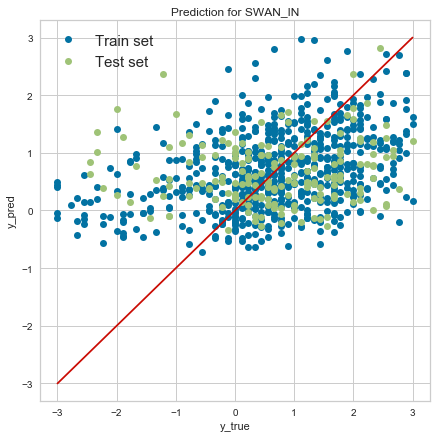

In [73]:
i=0
plt.figure(figsize=(7,7))
plt.plot( y_train.to_numpy()[:,i] ,  y_pred_train[:,i] , 'o', label = 'Train set ')
plt.plot( y_test.to_numpy()[: , i], y_pred_test[:,i] , 'o', label = 'Test set ')
line = np.linspace(np.min( y_train.to_numpy()[:,i]) , np.max( y_train.to_numpy()[:,i]) , 100)
plt.plot(line , line)
plt.title('Prediction for SWAN_IN')
plt.xlabel('y_true')
plt.ylabel('y_pred')
plt.legend(loc = 2, prop={'size': 15})
#plt.savefig('age_prediction_with_RF.png')
print('r2 = ' , r2[i] )

r2 =  -0.04656719633683526


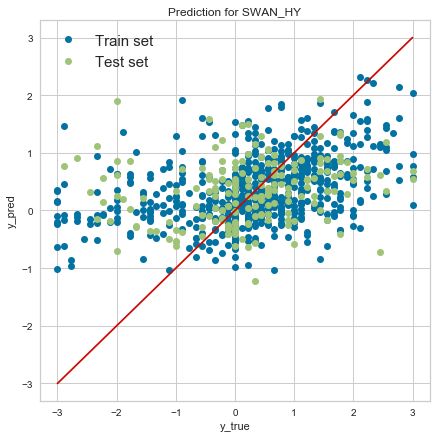

In [74]:
i=1
plt.figure(figsize=(7,7))
plt.plot( y_train.to_numpy()[:,i] ,  y_pred_train[:,i] , 'o', label = 'Train set ')
plt.plot( y_test.to_numpy()[: , i], y_pred_test[:,i] , 'o', label = 'Test set ')
line = np.linspace(np.min( y_train.to_numpy()[:,i]) , np.max( y_train.to_numpy()[:,i]) , 100)
plt.plot(line , line)
plt.title('Prediction for SWAN_HY')
plt.xlabel('y_true')
plt.ylabel('y_pred')
plt.legend(loc = 2, prop={'size': 15})
#plt.savefig('age_prediction_with_RF.png')
print('r2 = ' , r2[i] )

r2 =  -0.6351109249509763


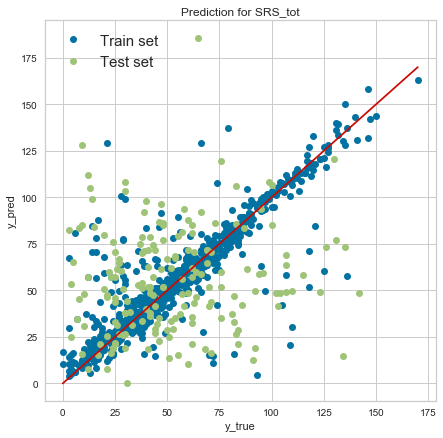

In [75]:
i=2
plt.figure(figsize=(7,7))
plt.plot( y_train.to_numpy()[:,i] ,  y_pred_train[:,i] , 'o', label = 'Train set ')
plt.plot( y_test.to_numpy()[: , i], y_pred_test[:,i] , 'o', label = 'Test set ')
line = np.linspace(np.min( y_train.to_numpy()[:,i]) , np.max( y_train.to_numpy()[:,i]) , 100)
plt.plot(line , line)
plt.title('Prediction for SRS_tot')
plt.xlabel('y_true')
plt.ylabel('y_pred')
plt.legend(loc = 2, prop={'size': 15})
#plt.savefig('age_prediction_with_RF.png')
print('r2 = ' , r2[i] )

r2 =  -0.31550071481617614


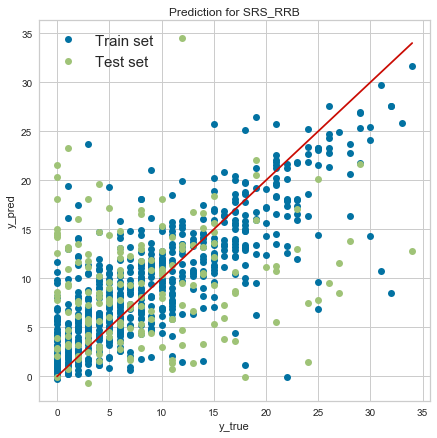

In [76]:
i=3
plt.figure(figsize=(7,7))
plt.plot( y_train.to_numpy()[:,i] ,  y_pred_train[:,i] , 'o', label = 'Train set ')
plt.plot( y_test.to_numpy()[: , i], y_pred_test[:,i] , 'o', label = 'Test set ')
line = np.linspace(np.min( y_train.to_numpy()[:,i]) , np.max( y_train.to_numpy()[:,i]) , 100)
plt.plot(line , line)
plt.title('Prediction for SRS_RRB')
plt.xlabel('y_true')
plt.ylabel('y_pred')
plt.legend(loc = 2, prop={'size': 15})
#plt.savefig('age_prediction_with_RF.png')
print('r2 = ' , r2[i] )

r2 =  -0.7228144950594659


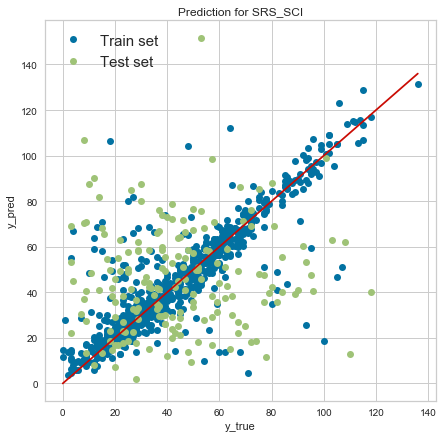

In [77]:
i=4
plt.figure(figsize=(7,7))
plt.plot( y_train.to_numpy()[:,i] ,  y_pred_train[:,i] , 'o', label = 'Train set ')
plt.plot( y_test.to_numpy()[: , i], y_pred_test[:,i] , 'o', label = 'Test set ')
line = np.linspace(np.min( y_train.to_numpy()[:,i]) , np.max( y_train.to_numpy()[:,i]) , 100)
plt.plot(line , line)
plt.title('Prediction for SRS_SCI')
plt.xlabel('y_true')
plt.ylabel('y_pred')
plt.legend(loc = 2, prop={'size': 15})
#plt.savefig('age_prediction_with_RF.png')
print('r2 = ' , r2[i] )